In [1]:
import torch
torch.cuda.is_available()

/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


True

In [3]:
%load_ext autoreload
%autoreload 2
import os
import json
from pathlib import Path
from cvla.utils_traj_tokens import getActionEncInstance

os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# dataset_location = "/tmp/cvla-clevr-8"
#dataset_location = "/data/lmbraid19/argusm/datasets/cvla-droid-block-simple-v3"
#dataset_location = "/data/lmbraid19/argusm/datasets/cvla-droid-block-v3"
#dataset_location = "/tmp/cvla-obja-camRF-sceneR-9-valid"

dataset_location =  "/work/dlclarge2/zhangj-zhangj-CFM/data/evaluate0"
#dataset_location = "/data/lmbraid19/argusm/datasets/cvla-obja-camRF-sceneR-9-valid"
#cvla-obja-camRF-sceneR-9-valid"
#clevr #obja
dataset_location = Path(dataset_location)

#model_location = Path("/data/lmbraid19/argusm/models/")
#model_path = model_location / "clevr-act-7-depth_text_aug" / "checkpoint-4687"
#model_path = model_location / "clevr-act-7-depth_e512s" / "checkpoint-4687"
#model_path = model_location / "mix30obj_text_debug" / "checkpoint-4687"
#model_path = model_location / "mix30obj_depth" / "checkpoint-4687"
#model_path = model_location / "mix30obj_mask" / "checkpoint-4687"

#model_path = Path("/work/dlclarge2/bratulic-cvla/models")  / "_text_lr3e-05_enc512_128d_depth_2025-04-29_10-38-15" / "checkpoint-4687"
#model_path = Path("/work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_based/checkpoint-2562")
#p0_topview/checkpoint-218")
model_path = Path("/work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_baseline/final_checkpoint")

#model_path = Path("/work/dlclarge2/bratulic-cvla/models")  / "_text_lr3e-05_enc512_256d_depth_2025-04-29_10-38-26" / "checkpoint-4687"

#model_path = model_location / "clevr-act-7-depth_e512s_depth" / "checkpoint-4687"
#model_path = model_location / "clevr-act-7-depth_depthaug" / "checkpoint-4687"

# some processing
info_file = model_path.parent / "cvla_info.json"
try:
    with open(info_file, "r") as f:
        model_info = json.load(f)
except FileNotFoundError:
    model_info = None

if model_info is not None:
    action_encoder = model_info["action_encoder"]
    return_depth = model_info["return_depth"]
else:
    action_encoder = "xyzrotvec-cam-512xy"
    return_depth = False
    if "_depth" in str(model_path):
        return_depth = True

enc_model = getActionEncInstance(action_encoder)
dataset_name = dataset_location.name
model_name = model_path.parent.name

print()
print("dataset:".ljust(10), dataset_name, dataset_location)
if model_path.is_dir():
    print("model:".ljust(10), model_name,"\t", model_path)
    print("encoder".ljust(10), action_encoder)
    print("depth:".ljust(10), return_depth)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

dataset:   evaluate0 /work/dlclarge2/zhangj-zhangj-CFM/data/evaluate0
model:     training2_topview_70000_baseline 	 /work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_baseline/final_checkpoint
encoder    xyzrotvec-cam-512xy
depth:     False


In [ ]:
#!nvidia-smi

In [4]:
from cvla.data_loader_jsonl import JSONLDataset
from cvla.data_loader_h5 import H5Dataset
from cvla.data_augmentations import CleanText, CropMiddle, CropCenter
import random
from torch.utils.data import Subset

if "-droid-" in str(dataset_location):
    #crop_augmentation = CropMiddle(crop_size=600, object_size=100, valid=True)
    crop_augmentation = CropCenter(crop_size=640)
    crop_augmentation = None
    clean_text = CleanText(truncate_len=75)
    test_dataset = JSONLDataset(
        jsonl_file_path=dataset_location,
        action_encoder=enc_model.NAME,
        augment_text=clean_text,
        return_depth=return_depth,
        limit_samples=20,
        augment_crop=crop_augmentation,
        split="valid"
    )
else:
    test_dataset = H5Dataset(dataset_location, return_depth=return_depth, action_encoder=action_encoder)


n_sample = min(1000, len(test_dataset))
indices = random.sample(range(len(test_dataset)), n_sample)
testsub_dataset = Subset(test_dataset, indices)
print("subset len:", len(testsub_dataset))
print("dataset len", len(test_dataset))
print("Dataset encoder:" , test_dataset.action_encoder.NAME)
enc_model = enc_model
enc_data = test_dataset.action_encoder

subset len: 1000
dataset len 3000
Dataset encoder: xyzrotvec-cam-512xy


1000
<class 'torch.utils.data.dataset.Subset'>


  0%|          | 0/15 [00:00<?, ?it/s]


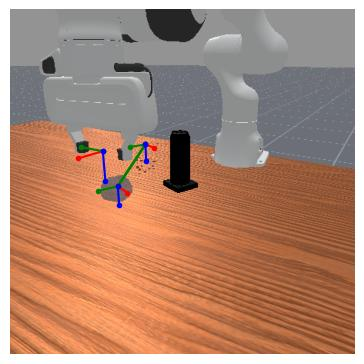
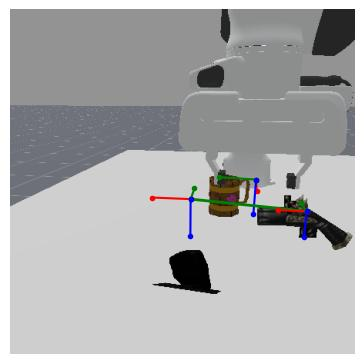
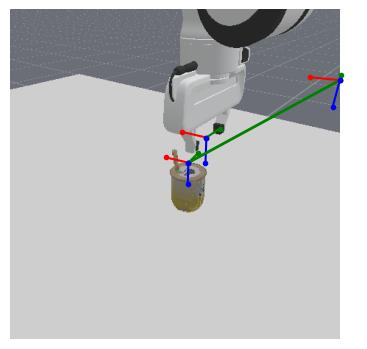
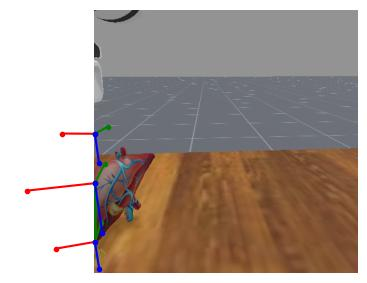
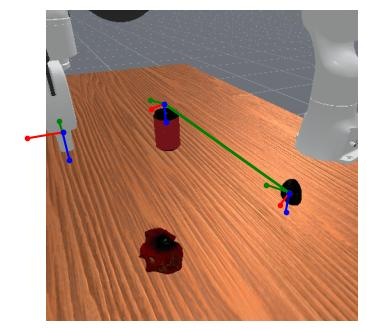
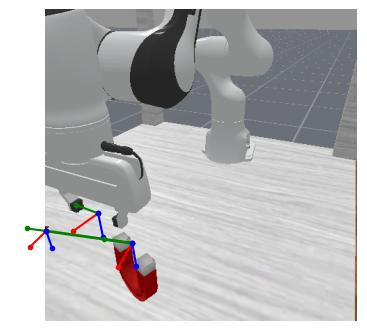
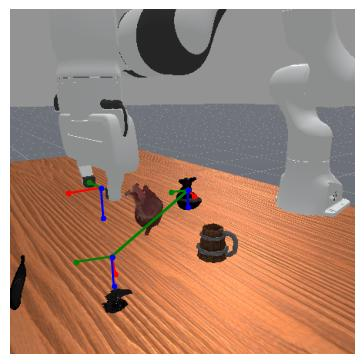
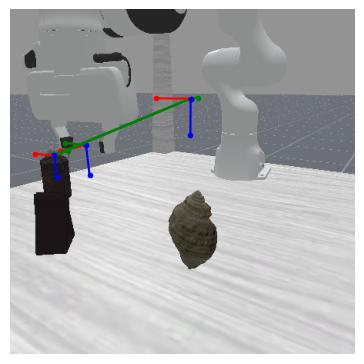
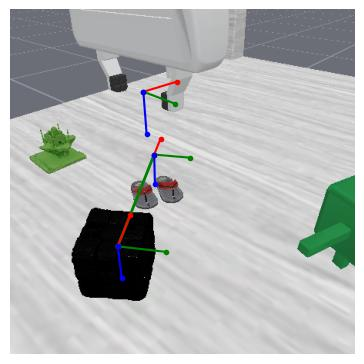
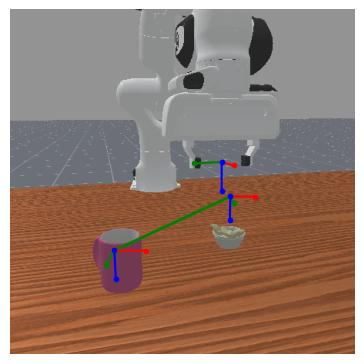
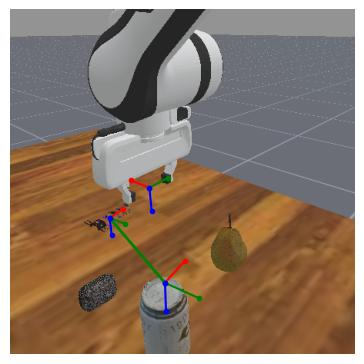
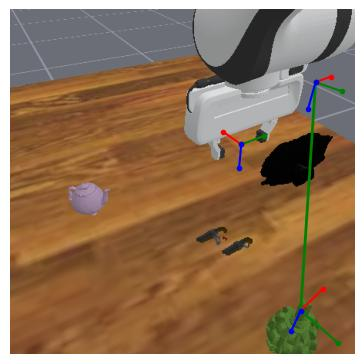
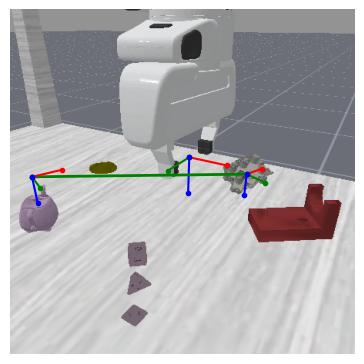
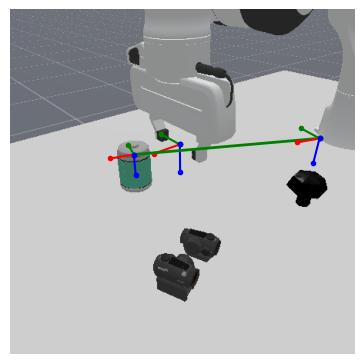
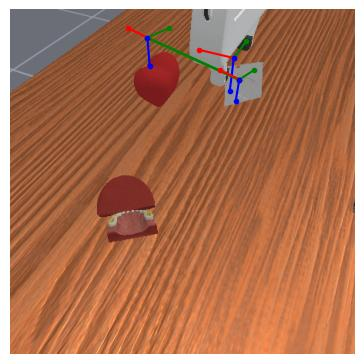

In [5]:
from IPython.display import display, HTML
from cvla.utils_vis import render_example
from tqdm.notebook import tqdm

def get_image(images):
    if isinstance(images, (list, tuple)):
        return images[0]
    else:
        return images
    
def get_depth(images):
    if isinstance(images, (list, tuple)):
        return images[-1]
    else:
        return None
    
print(len(testsub_dataset))
print(type(testsub_dataset))
num_samples = min(15, len(testsub_dataset))
html_imgs = ""
for i in tqdm(range(num_samples)):
    images, sample = testsub_dataset[i]
    image = get_image(images)
    #image = get_depth(images)
    html_imgs += render_example(image, label=sample["suffix"], text=sample["prefix"], camera=sample["camera"], enc=enc_data, enc_pred=enc_model, i=f"s_{i}")
    print(sample["camera"])
display(HTML(html_imgs))

In [6]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.bfloat16
print('Using device:', DEVICE)

MODEL_ID ="google/paligemma2-3b-pt-224"
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)
print("loaded processor.")
model = PaliGemmaForConditionalGeneration.from_pretrained(model_path, torch_dtype=TORCH_DTYPE, device_map="auto")
#model.to(DEVICE)

Using device: cuda
loaded processor.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
for name, param in model.named_parameters():
    print(name, param.dtype)
    break  

In [7]:
def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image>" + label["prefix"] for label in labels]
    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)
    return inputs

if return_depth:
    def collate_fn(batch):
        images, labels = zip(*batch)
        prefixes = ["<image><image>" + label["prefix"] for label in labels]
        images_flat = [img for img_list_x in images for img in img_list_x]
        inputs = processor(
            text=prefixes,
            images=images_flat,
            return_tensors="pt",
            padding="longest"
        ).to(TORCH_DTYPE).to(DEVICE)
        return inputs

In [8]:
model.to(DEVICE)

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipSdpaAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_features

In [9]:
from math import ceil
from tqdm.notebook import tqdm

eval_batch_size = 1

#test_samples = eval_batch_size*3
test_samples = min(len(test_dataset), 100)#500)
predictions = {}
for start_idx in tqdm(range(0, test_samples, eval_batch_size), total=ceil(test_samples / eval_batch_size)):
    batch_i = range(start_idx, min(start_idx + eval_batch_size, test_samples))
    batch = [test_dataset[i] for i in batch_i]
    inputs = collate_fn(batch)
    prefix_length = inputs["input_ids"].shape[-1]    

    with torch.inference_mode():
        generation = model.generate(**inputs, max_new_tokens=13, do_sample=False, use_cache=False)
        decoded = [processor.decode(x, skip_special_tokens=True) for x in generation[:, prefix_length:]]
        
    for k,v in zip(batch_i, decoded):
        #print(v)
        predictions[k] = v 

  0%|          | 0/100 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/pyt

In [ ]:
import json

# 转换键为字符串
predictions_str_keys = {str(k): v for k, v in predictions.items()}

with open("predictions.json", "w") as f:
    json.dump(predictions_str_keys, f, indent=2)

In [ ]:
from cvla.utils_vis import render_example

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:00, ?it/s]


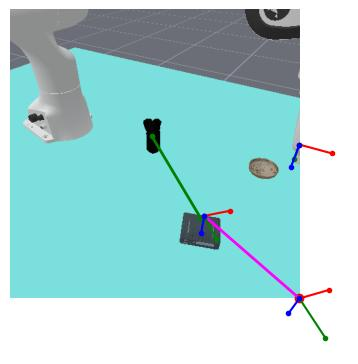
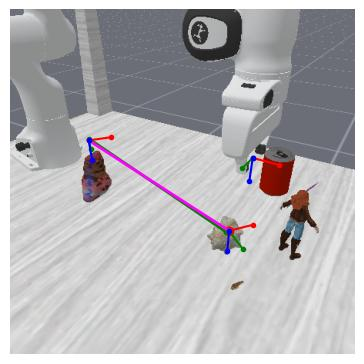
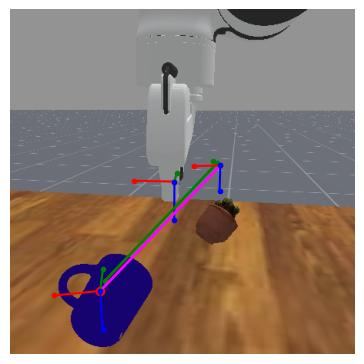
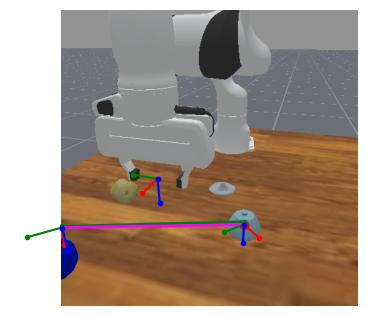
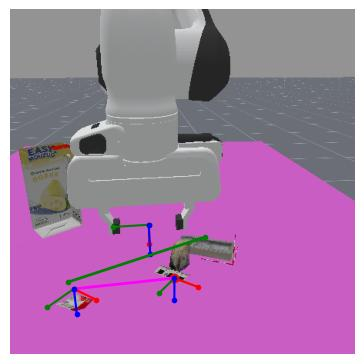

In [10]:
%load_ext autoreload
%autoreload 2
from cvla.utils_vis import render_example

plot_images = 5

html_imgs = ""
for _, (dataset_index, decoded_str) in tqdm(zip(range(plot_images),predictions.items())):
    batch_entry = test_dataset[dataset_index]
    if return_depth:
        (depth, image), sample = batch_entry
    else:
        image, sample = batch_entry
    image = image.to(torch.float32) if isinstance(image, torch.Tensor) else image
    html_img = render_example(image, text=sample["prefix"], label=sample["suffix"], prediction=decoded_str, camera=sample["camera"],
                              enc=enc_data, enc_pred=enc_model)
    html_imgs += html_img

from IPython.display import display, HTML
display(HTML(html_imgs))

In [ ]:
test_dataset[0][1]["camera"]

image size: 448 448


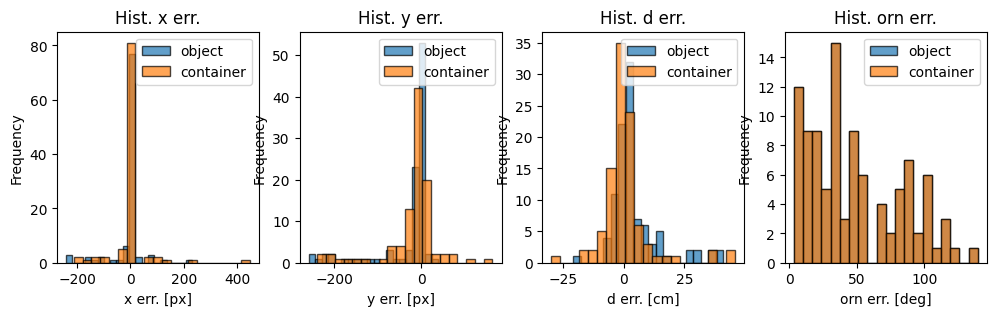

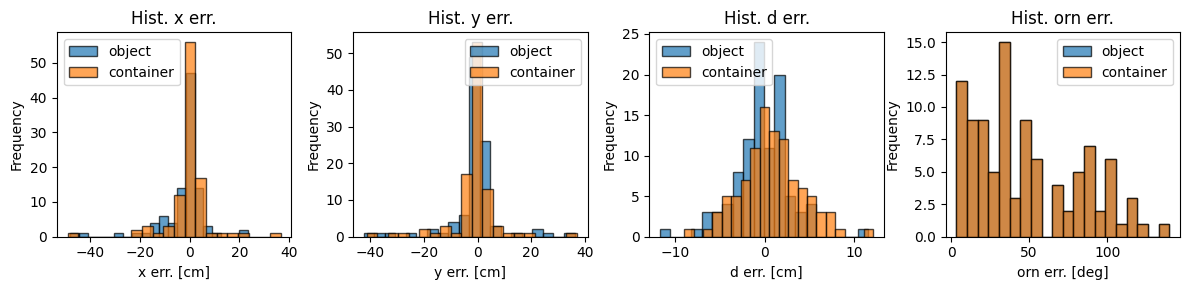

model training2_topview_70000_baseline (rgb   )
dataset evaluate0
valid_samples 100 samples 100 valid_rate 1.00
x  l2: 902.37 px l1: 24.53 px
y  l2: 960.30 px l1: 33.83 px
d  l2: 154.31 cm l1: 6.25 cm
orn l2: 843.97 deg l1: 48.84 deg
training2_topview_70000_baseline (rgb   ) L1: 28.363 L1_2d 29.179 px L1_depth: 6.255 cm L1_depth_obj: 6.520 cm cam evaluate0-len=3000

x  l2: 127.24 cm l1: 4.63 cm
y  l2: 131.33 cm l1: 4.74 cm
d  l2: 46.98 cm l1: 2.45 cm
orn l2: 843.97 deg l1: 48.84 deg
training2_topview_70000_baseline (rgb   ) L1: 15.166 L1_2d 4.685 cm L1_depth: 2.454 cm L1_depth_obj: 2.210 cm cart evaluate0-len=3000



{'cam_x_l2': 902.3657264162674,
 'cam_x_l1': 24.5304114818573,
 'cam_y_l2': 960.2993940416198,
 'cam_y_l1': 33.82794399261475,
 'cam_d_l2': 154.3081281582707,
 'cam_d_l1': 6.254999628663063,
 'cam_orn_l2': 843.9698612167875,
 'cam_orn_l1': 48.839339156354384,
 'cam_l1': 28.36317356487237,
 'cam_l2': 1572.4296345037044,
 'cam_d_obj_l1': 6.519999680519104,
 'cart_x_l2': 127.24415753018208,
 'cart_x_l1': 4.632313930541277,
 'cart_y_l2': 131.33201337190303,
 'cart_y_l1': 4.737850427776575,
 'cart_d_l2': 46.97761762320894,
 'cart_d_l1': 2.453884586393833,
 'cart_orn_l2': 843.969860084208,
 'cart_orn_l1': 48.83933907772118,
 'cart_l1': 15.165847005608216,
 'cart_l2': 864.8301536428952,
 'cart_d_obj_l1': 2.209683849811554,
 'valid_counter': 1.0}

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from cvla.utils_eval import Evaluator, check_if_valid

camera = test_dataset[0][1]["camera"]
evaluator = Evaluator(enc_model, camera_fixed=camera, encoder_labels=test_dataset.action_encoder)

valid_map={}
nvalid_map={}
tmp_c = 0
tmp_nc = 0

for i, pred in predictions.items():
    entry = test_dataset[i][1] 
    if i == 0:
        print("image size:", entry["camera"].width, entry["camera"].height)
    suffix = entry["suffix"]
    camera = entry["camera"]

    if not check_if_valid(pred, suffix):   # either not enough tokens or wrong order
            print("skipping", i, pred, len(pred), suffix)
            nvalid_map[tmp_nc] = i
            tmp_nc += 1 
            continue
    
    valid_map[tmp_c] = i
    tmp_c+=1
    evaluator.evaluate(pred, suffix, camera)

stats_report = evaluator.report_stats()

valid_diffs = evaluator.valid_diffs

keypoint = ["object","container"]
action_labels = ["x","y","d","orn"]*2
units = dict(cam=["px","px","cm","deg"]*2, cart=["cm","cm","cm","deg"]*2)

plot_hist = True
if plot_hist:
    for mode, valid_diff in valid_diffs.items():
        valid_diff = valid_diffs[mode]
        fig, axes = plt.subplots(1, 4, figsize=(12, 12*1/4))  # 3 rows x 4 columns of histograms
        axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
        for i in range(2):
            for j in range(4):  # x, y, d
                axes[j].hist(valid_diff[:, i,j], bins=20, alpha=0.7,  edgecolor='black', label=keypoint[i])
                axes[j].set_title(f'Hist. {action_labels[j]} err.')
                axes[j].set_xlabel(f"{action_labels[j]} err. [{units[mode][j]}]")
                axes[j].set_ylabel('Frequency')
                axes[j].legend()
    plt.tight_layout()
    plt.show()

depth_str = "depth" if return_depth else "rgb   "
print(f"model {model_name} ({depth_str})\ndataset {dataset_name}")
print(f"valid_samples", len(valid_diffs["cam"]), "samples", len(predictions), "valid_rate", f"{len(valid_diffs["cam"])/len(predictions):0.2f}")
for mode, valid_diff in valid_diffs.items():
    for i, action_label in enumerate(action_labels[:4]):
        print(f"{action_label.ljust(2)} l2: {np.linalg.norm(valid_diff[:,:,i]):0.2f} {units[mode][i]} l1: {np.mean(np.abs(valid_diff[:,:,i])):0.2f} {units[mode][i]}")
    l1 = np.mean(np.abs(valid_diff))
    l1_2d = np.mean(np.abs(valid_diff[:,:,:2]))
    l1_depth = np.mean(np.abs(valid_diff[:,:,2]))
    l1_depth_obj = np.mean(np.abs(valid_diff[:,0,2]))
    out_str = f"{model_name} ({depth_str}) L1: {l1:0.3f} L1_2d {l1_2d:0.3f} "
    out_str += f"{units[mode][0]} L1_depth: {l1_depth:0.3f} {units[mode][2]} L1_depth_obj: {l1_depth_obj:0.3f} {units[mode][2]} {mode} "
    out_str += f"{dataset_name}-len={len(test_dataset)}"
    print(out_str)
    print()

stats_report

In [ ]:
html_imgs = ""
for i in range(min(39, len(nvalid_map))):
    dataset_i = nvalid_map[i]
    batch_entry = test_dataset[dataset_i]
    print(dataset_i)
    if return_depth:
        (depth, image), sample = batch_entry
    else:
        image, sample = batch_entry

    decoded_str = predictions[dataset_i]
    html_img = render_example(image, text=sample["prefix"], label=sample["suffix"], prediction=decoded_str, camera=sample["camera"],
                              enc=enc_data, enc_pred=enc_model)
    html_imgs += html_img


display(HTML(html_imgs))
    

In [ ]:
import re

MOVE_REGEX = re.compile(r"^move\s+([\w',.-]+(?:\s+[\w',.-]+)*)\s+onto\s+([\w',.-]+(?:\s+[\w',.-]+)*)$")

text = "move mr. potohead onto blue block"
match = MOVE_REGEX.match(text.strip())
print(match.groups())


```
mix30obj_text (rgb   ) L1: 75.920 L1_2d 60.521 px L1_depth: 14.226 cm L1_depth_obj: 13.250 cm cam cvla-droid-1of5c-v1-len=200
clevr-act-7-depth_e512s (rgb   ) L1: 77.966 L1_2d 67.927 px L1_depth: 12.432 cm L1_depth_obj: 11.803 cm cam cvla-droid-1of5c-v1-len=200
clevr-act-7-depth_text_aug (rgb   ) L1: 92.865 L1_2d 95.115 px L1_depth: 16.793 cm L1_depth_obj: 13.647 cm cam cvla-droid-1of5c-v1-len=200


#clevr-act-7-depth_depthaug (depth) L1: 39.406 L1_depth: 8.897 cm L1_depth_obj: 5.356 cm cam
#clevr-act-7-depth_depthaug (depth) L1: 16.043 L1_depth: 3.531 cm L1_depth_obj: 2.930 cm cart

#clevr-act-7-depth_text_aug (rgb   ) L1: 35.151 L1_depth: 11.916 cm L1_depth_obj: 7.575 cm cam
#clevr-act-7-depth_text_aug (rgb   ) L1: 17.952 L1_depth: 4.256 cm L1_depth_obj: 3.442 cm cart



# RGB Networks
# Valid Samples: 157 L1: 35.67 (no-agug)
# Valid Samples: 160 L1: 34.35 (prompt cleaning) 33.89
# Valid Samples: 160 L1: 34.62 (prompt cleaning + simplify text)  -- similar

# Valid Samples: 160 L1: 24.96 (rgb20 = augmentation + random background (CVPR09-dataset))
# Valid Samples: 160 L1: 26.61 (rgb20 + simplify text) -- worse
# Valid Samples: 150 L1: 40.55 (augmentation + DROID background)  -- way worse

# With depth (only 31 samples for real data)
# Valid Samples: 31 L1: 29.24 (no text aug, NaN-to-Max eval)
# Valid Samples: 31 L1: 28.58  L1_depth 6.29375 (no text aug, Nan-to-Min eval)  
# Valid Samples: 160 L1: 27.93 6.29375 (no text aug, all-zero)

# clevr-act-7-depth_text_aug (rgb  ) L1: 13.994 L1_depth: 11.916 L1_depth_obj: 7.575
# clevr-act-7-depth_depthaug (depth) L1: 14.677 L1_depth: 8.897 L1_depth_obj: 5.356 

```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.array([13.68125, 48.0125 ,  8.025  ,  8.475  , 20.1875 , 29.4    ,  # without masking v3
        5.2875 ,  4.00625, 15.20625,  8.475  , 20.1875 , 29.4    ])

np.array([ 5.76875, 14.11875,  7.275  , 36.9875 , 53.45   , 18.25625,  # with masking v2 (wrong orientation)
        8.94375,  7.0375 , 16.825  , 36.9875 , 53.45   , 18.25625])



eval_on_blocks = {"baseline":35.67, "+clean prompt": 33.89, "(simplify text)":34.62,
                  "rbg-20%": 24.96, "(droid bg)": 40.55, "text aug": 25.93}


# Extract labels and values
labels, values = zip(*eval_on_blocks.items())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue', edgecolor='black')

# Formatting
plt.ylabel("L1 Error Mean")
plt.title("Evaluation over Training Data")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.xlabel("Experiment Runs")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add grid lines for readability

# Show plot
plt.show()

In [ ]:
plt.imshow(np.abs(valid_diffs["cart"][:,:,0:3].reshape(-1,6)))
#-np.max
#worst_position = np.argsort(-np.max(np.abs(valid_diffs["cam"][:,:,2:3]),axis=(1,2)))
worst_position = np.argsort(-np.sum(np.abs(valid_diffs["cam"][:, :, :3]), axis=(1, 2)))

html_imgs = ""
for i in range(min(39,len(worst_position))):
    dataset_i = valid_map[worst_position[i]]
    batch_entry = test_dataset[dataset_i]
    if return_depth:
        (depth, image), sample = batch_entry
    else:
        image, sample = batch_entry

    decoded_str = predictions[dataset_i]
    html_img = render_example(image, text=sample["prefix"], label=sample["suffix"], prediction=decoded_str, camera=sample["camera"],
                              enc=enc_data, enc_pred=enc_model)
    html_imgs += html_img


display(HTML(html_imgs))
    

# Simulation Eval

In [ ]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
from cvla.hf_model_class import cVLA_wrapped
from cvla.data_loader_h5 import H5Dataset
from cvla.data_loader_paired import PairedDataset
from cvla.utils_eval import Evaluator

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
import getpass

username = getpass.getuser()
username = "bratulic"

if username == "bratulic":
    model_root = Path("/work/dlclarge2/bratulic-cvla/models/clevr-act-7-depth_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_nexEnc_RealEval_baseline_augs_2025-04-11_15-52-11")
    model_path = model_root / "checkpoint-1750"
    model_root2 = Path("/work/dlclarge2/bratulic-cvla/models/clevr-act-7-depth_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_NexEnc_augs_2025-04-10_16-32-05")
    model_path2 = model_root2 / "checkpoint-1200"
    model_root3 = Path("/work/dlclarge2/bratulic-cvla/models/clevr-act-7-depth_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_nexEnc_RealEval_baseline_pc25_psim25_CameraPos_augs_2025-04-11_16-03-29")
    model_path3 = model_root3 / "checkpoint-2000"
    v1 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05debug_2025-04-17_22-56-25"
    v2 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_2025-04-17_23-45-32"
    v3 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_copy025_2025-04-17_23-46-00"
    v4 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_copy025_sort025_cameraSort_2025-04-17_23-45-04"
    v5 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_copy025_sort025_trajSort_2025-04-17_23-47-43"
    v6 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_pBackground02_2025-04-17_23-45-38"
    v7 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_pBackground02_copy025_2025-04-17_23-43-08"
    v8 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_pBackground02_copy025_sort025_cameraSort_2025-04-17_23-46-50"
    v9 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_augs_pBackground02_copy025_sort025_trajSort_2025-04-17_23-48-00"
    v10 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_noAugs_2025-04-17_23-45-28"
    v11 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_noAugs_copy025_2025-04-17_23-45-39"
    v12 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_noAugs_copy025_sort025_cameraSort_2025-04-17_23-44-44"
    v13 = "cvla-clevr-8_img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_randomSampling_newData_noAugs_copy025_sort025_trajSort_2025-04-17_23-47-05"


    v14 = "cvla-clevr-camRF-sceneR-9__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_samplingAll_augs_2025-04-24_16-48-19" # 1 - 11
    #v15 = "cvla-clevr-camRF-sceneR-9__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_samplingAll_augs_warmup5_depthBoth_2025-04-25_16-46-38" # 1 - 11
    #v16 = "cvla-clevr-camRF-sceneR-9__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_samplingAll_augs_warmup5_depthOne_2025-04-25_07-51-29" # 8 - 22
    v17 = "cvla-clevr-camRF-sceneR-9__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_sortAll_augs_max20k_2025-04-27_18-00-52" # 6 - 20

    #v18 = "cvla-clevr-8__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_samplingAll_augs_warmup5_depth_2025-04-25_16-50-26" # 1k - 9k
    #v19 = "cvla-clevr-8__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_samplingAll_augs_warmup5_depthBoth_2025-04-25_16-49-38" # 1k - 7k
    v20 = "cvla-clevr-8__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_sortAll_augs_max20k_2025-04-27_21-42-41" # 16 - 20
    v21 = "cvla-clevr-8__img_1_pr_interleaved_enc_xyzrotvec-cam-512xy128dmaxTokens13_lr3e-05_samplingAll_w05_maxSteps20k_2025-04-27_09-38-37" # 1 - 3

    model_path = Path("/work/dlclarge2/bratulic-cvla/models/") / v17 / "checkpoint-19000"

elif username == "argusm":
    model_location = Path("/data/lmbraid19/argusm/models/")
    #run = "_text_lr3e-05xyzrotvec-cam-1024xy_2025-04-23_11-04-12" # done
    #run = "_text_lr3e-05xyzrotvec-cam-512xy_2025-04-23_11-04-16"
    #run = "_text_lr3e-05xyzrotvec-cam-256xy_2025-04-27_13-37-35"
    #run = "_text_lr3e-05xyzrotvec-cam-128xy_2025-04-27_13-37-35"
    #run = "_text_lr3e-05xyzrotvec-rbt-100_2025-04-27_20-14-08"
    #run = "_text_lr3e-05xyzrotvec-rbt-128_2025-04-27_20-14-08"
    #run = "_text_lr3e-05xyzrotvec-rbt-256_2025-04-27_15-55-37"
    #run = "_text_lr3e-05xyzrotvec-rbt-512_2025-04-28_15-10-30"
    #run = "_text_lr3e-05xyzrotvec-rbt-1024_2025-04-28_15-10-30"
    run = "_text_lr3e-05xyzrotvec-cam-512xy256d_2025-04-23_12-03-48" # done
    #run = "_text_lr3e-05xyzrotvec-cam-512xy128d_2025-04-27_13-37-35"
    
    model_path = model_location / run / "checkpoint-4687"

#for success rate
model_path = Path("/work/dlclarge2/bratulic-cvla/models")  / "_text_lr3e-05_enc512_128d_depth_2025-04-29_10-38-15" / "checkpoint-4687"

print(username)
print(model_path)
model_wrapped = cVLA_wrapped(model_path=model_path)
model_wrapped.print_summary()

In [ ]:
conditioning = "text"
if username == "bratulic":
    conditioning = "trajectory"

if conditioning == "trajectory":
    # simulation clevr dataset for testing
    if "cvla-clevr-8" in str(model_path):
        dataset_location = Path("/data/lmbraid19/argusm/datasets/cvla-clevr-8-valid")
        #dataset_location = Path("/tmp/cvla-clevr-8-valid")
    else:
        dataset_location = Path("/data/lmbraid19/argusm/datasets/cvla-clevr-camRF-sceneR-9-valid")
        #dataset_location = Path("/tmp/cvla-clevr-camRF-sceneR-9-valid")
    num_images_in_context = 1
    image_order = "interleaved"
    action_encoder = model_wrapped.enc_model.NAME
    raw_dataset = H5Dataset(dataset_location, action_encoder=action_encoder)
    run_name = f"_img_{num_images_in_context}_pr_{image_order}_enc_{action_encoder}"
    load_presampled_pairs_path = Path("/data/lmbraid21/bratulic/max_pali/datasets") / f"{dataset_location.name}_{run_name}_new.pkl"
    presampled_eval_sequences_path = Path("/data/lmbraid21/bratulic/max_pali/datasets") / f"{dataset_location.name}_{run_name}_pCopy0_pSorting0_presampled_eval_sequences.pkl"
    demonstration_dataset = PairedDataset(raw_dataset, num_images_in_context=num_images_in_context, image_order=image_order, load_presampled_pairs_path=load_presampled_pairs_path, plot_statistics=False,
                                p_copy=0.0, p_sort_by_l2_distance=0.0, presampled_path=presampled_eval_sequences_path, mode="test", sort_criteria="trajectory_shape")
    model_wrapped.set_conditioning_dataset(demonstration_dataset)
    dummy_camera = raw_dataset[0][1]["camera"]
    evaluator = Evaluator(model_wrapped.enc_model, dummy_camera)
else:
    dummy_camera = None
    evaluator = None

In [ ]:
import random
import os
from pathlib import Path
from mani_skill.examples.cvla.run_env import Args, iterate_env

model_path = Path("/work/dlclarge2/bratulic-cvla/models")  / "_text_lr3e-05_enc512_128d_depth_2025-04-29_10-38-15" / "checkpoint-4687"
conditioning = "trajectory"


parsed_args = Args()
if conditioning == "trajectory" and "depth" not in str(model_path):
    parsed_args.obs_mode = "rgb"    # for trajs we need only image
parsed_args.env_id = "CvlaMove-v1"#"ClevrMove-v1"
parsed_args.render_mode = "rgb_array"
parsed_args.control_mode = "pd_joint_pos"
parsed_args.camera_views = "random_side"
if conditioning == "trajectory":
    if "cvla-clevr-8" in str(model_path):           # models trained on  clevr-8 should be evaluated on clevr-8
        parsed_args.camera_views = "random_side"
    else:
        parsed_args.camera_views = "random_fov"
# parsed_args.quiet = True
parsed_args.verbose = True
parsed_args.object_dataset = "objaverse"
parsed_args.quiet = True
#parsed_args.action_encoder = model_wrapped.enc_model.NAME
parsed_args.record_dir = "/tmp/cvla-rec-video"
os.makedirs("/tmp/cvla-rec-video",exist_ok=True)

inital_seed = 2919129908
random.seed(inital_seed)
seeds = random.sample(range(0, 2**32), 50)
parsed_args.seed = seeds

print(parsed_args)

env_iter = iterate_env(parsed_args, vis=False, model=model_wrapped)

In [ ]:
print(model_wrapped)

In [ ]:
print(parsed_args)

In [ ]:
print(parsed_args.seed)

In [ ]:
#%xmode verbose
iters_reached = 0
num_iters = 50
reward_succes = 0

worst_examples = []  # Store tuples of (reward, json_dict)

for i in range(num_iters):
    try:
        output = next(env_iter)
        print(output)
    except (ValueError, AssertionError, StopIteration) as e:
        print(f"Encountered error {e.__class__.__name__}")
        print(f"Skipping iteration {i}")
        print(e)
        #traceback.print_exc()  # Prints the full traceback
        continue
    
    json_dict = output[1]
    print(f"TRY {i:<2} Prefix: {json_dict['prefix']:<100} -> {json_dict['reward']:.2f}")
    print(json_dict["suffix"])
    print(json_dict["prediction"])

    if evaluator:
        evaluator.evaluate(json_dict["prediction"], json_dict["suffix"])
    iters_reached = json_dict["iter_reached"]
    if json_dict["reward"] > 0.75:
        reward_succes += 1
    worst_examples.append((reward, json_dict))

# After loop
worst_examples.sort(key=lambda x: x[0])  # Sort by reward ascending
num_worst = max(1, int(0.1 * len(worst_examples)))  # Get bottom 10%
worst_10_percent = worst_examples[:num_worst]

print("\n--- Worst Performing Examples (Bottom 10%) ---")
for reward, example in worst_10_percent:
    print(f"Reward: {reward:.2f} | Prefix: {example['prefix']}")
    print(f"Ground Truth (Suffix): {example['suffix']}")
    print(f"Prediction: {example['prediction']}\n")
    
if evaluator:
    stats = evaluator.report_stats()
    for metric_name, metric_value in stats.items():
        print(f"{metric_name}: {metric_value:.3f}")
    evaluator.reset()

iters_reached += 1  # starts with 0 so we add 1 to it

print(f"\nTotal number of tries {iters_reached} for {num_iters} tries gaves {100*num_iters / iters_reached:.2f}% valid sequence rate.")
print(f"Reward success rate: {100*reward_succes / num_iters:.2f}%")


In [ ]:
model_wrapped.print_summary()
#print(demonstration_dataset.task_lookup.keys())

In [ ]:
# Line "cam"
# xyzrotvec-cam-1024xy 44%
# xyzrotvec-cam-512xy 34%
# xyzrotvec-cam-256xy 40%
# xyzrotvec-cam-128xy 20%

# Line "rbt"
# xyzrotvec-rbt-512 38%
# xyzrotvec-rbt-256 18%
# xyzrotvec-rbt-128 22%
# xyzrotvec-rbt-100 8%

# Line "cam-256d"
# xyzrotvec-cam-512xy256d 44%

# Line "cam-128d"
# xyzrotvec-cam-512xy128d 36%





In [ ]:


inital_seed = 2919129908
random.seed(inital_seed)
seeds = random.sample(range(0, 2**32), 50)
print(" ".join([str(x) for x in seeds]))

In [ ]:
from scipy.stats import norm
import numpy as np

def two_proportion_z_test(p1, n1, p2, n2):
    # Pooled proportion
    p_pool = (p1 * n1 + p2 * n2) / (n1 + n2)
    # Standard error
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    # z-score
    z = (p1 - p2) / se
    # two-tailed p-value
    p_value = 2 * (1 - norm.cdf(abs(z)))
    return z, p_value

# Example usage
p1 = 0.44  # success rate 1
n1 = n2 = 600  # number of samples 1
p2 = 0.38  # success rate 2

z_score, p_val = two_proportion_z_test(p1, n1, p2, n2)
print(f"z-score: {z_score:.3f}, p-value: {p_val:.3f}")

if p_val < 0.05:
    print("Difference is statistically significant.")
else:
    print("Difference is not statistically significant.")

In [ ]:
import matplotlib.pyplot as plt

# Define the data
x_values = [128, 256, 512, 1024]
cam_values = [20, 40, 34, 44]
rbt_x = [100, 128, 256, 512]
rbt_values = [8, 22, 18, 38]
cam_256d_x = [512]
cam_256d_values = [44]
cam_128d_x = [512]
cam_128d_values = [36]

# Create the plot
plt.figure(figsize=(4, 3))
plt.plot(rbt_x, rbt_values, marker='o', label='robot')
plt.plot(x_values, cam_values, marker='o', label='camera')
plt.plot(cam_256d_x, cam_256d_values, marker='o', label='camera-256d')
plt.plot(cam_128d_x, cam_128d_values, marker='o', label='camera-128d')

plt.xlabel('Action Resolution (Logit Num.)')
plt.ylabel('Success Rate (%)')
#plt.title('Success Rate vs Action Resolution')
plt.xticks([128, 256, 512, 1024])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("action_resolution_sr.pdf")

plt.show()


# Create Videos

In [ ]:
import os

video_dir = "/tmp/cvla-rec-video"

# Get list of .h5 files with their sizes
h5_files = [
    (f, os.path.getsize(os.path.join(video_dir, f)))
    for f in os.listdir(video_dir)
    if f.endswith('.h5')
]
print(h5_files)

# Select the file with the maximum size
if h5_files:
    largest_file = max(h5_files, key=lambda x: x[1])[0]
    print(f"Largest .h5 file: {largest_file}")
else:
    print("No .h5 files found.")





In [ ]:
from pathlib import Path

import cv2
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from cvla.data_loader_h5 import H5Dataset

dataset_location = Path(video_dir) / largest_file
dataset = H5Dataset(dataset_location)
video_dir = Path(video_dir)
output_path = video_dir / "run_0.mp4"

for key in tqdm(sorted(dataset.h5_file.keys())):
    frames = dataset.h5_file[f"{key}/obs/sensor_data/render_camera/rgb"]

    # Define video parameters
    height, width = frames.shape[1:3]
    fps = 30  # or whatever frame rate you want
    output_path = video_dir / f'video_obja_{key}.mp4'

    # Define the video writer using MP4 codec
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1'
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write each frame
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # OpenCV expects BGR
        out.write(frame_bgr)

    out.release()
    print(f"Video saved to {output_path}")